# Features 6: Position of clicked link on the article


## Importing libraries 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
import sys

## Loading the data

In [2]:
DATA_FOLDER = "../data/"
PATHS_AND_GRAPH = DATA_FOLDER + "wikispeedia_paths-and-graph/"
PATHS_FINISHED = PATHS_AND_GRAPH + "paths_finished.tsv"
PATHS_UNFINISHED = PATHS_AND_GRAPH + "paths_unfinished.tsv"

In [3]:
# loading finished paths
paths_finished = pd.read_csv(
    PATHS_FINISHED,
    sep="\t",
    header=None,
    names=["hashedIpAddress", "timestamp", "durationInSec", "path", "rating"],
    encoding="utf-8",
    skiprows=16,
).copy(deep=True)
paths_finished["timestamp"] = pd.to_datetime(paths_finished["timestamp"], unit="s")

In [4]:
# loading unfinished paths
paths_unfinished = pd.read_csv(
    PATHS_UNFINISHED,
    sep="\t",
    header=None,
    names=["hashedIpAddress", "timestamp", "durationInSec", "path", "target", "type"],
    encoding="utf-8",
    skiprows=17,
).copy(deep=True)
paths_unfinished["timestamp"] = pd.to_datetime(paths_unfinished["timestamp"], unit="s")

## Loading additional datasets needed for path length feature

In [5]:
# Loading shortest path distance matrix
SHORTEST_PATH_MATRIX = PATHS_AND_GRAPH + "shortest-path-distance-matrix.txt"
shortest_path_distance_matrix = pd.read_csv(
    SHORTEST_PATH_MATRIX,
    sep="\t",
    names=["shortest path"],
    header=None,
    encoding="utf-8",
    skiprows=17,
).copy(deep=True)
shortest_path_distance_matrix = shortest_path_distance_matrix["shortest path"].apply(
    lambda x: list(x)
)  # splitting string into list

In [6]:
# loading articles dataset
ARTICLES = PATHS_AND_GRAPH + "articles.tsv"
articles = pd.read_csv(
    ARTICLES,
    sep="\t",
    header=None,
    encoding="utf-8",
    names=["article name"],
    skiprows=12,
).copy(deep=True)

## 

# Feature 6: Position of clicked link on the article
Let's find the position of clicked link on article page \
To do so, we looked for the word count to link on html page for second element in successive_pairs in first elements html page 

1) Removing back clicks and splitting paths...
100%|██████████| 24875/24875 [00:05<00:00, 4169.26it/s]
2) Computing position for every successive pair in finished and unfinished paths...
100%|██████████| 24875/24875 [00:03<00:00, 6731.00it/s]
3) Looking at character count before clicked link for every edge and for every player...
Average character count before clicked link in finished paths 8401.92 
Average character count before clicked link in unfinished paths 7964.08


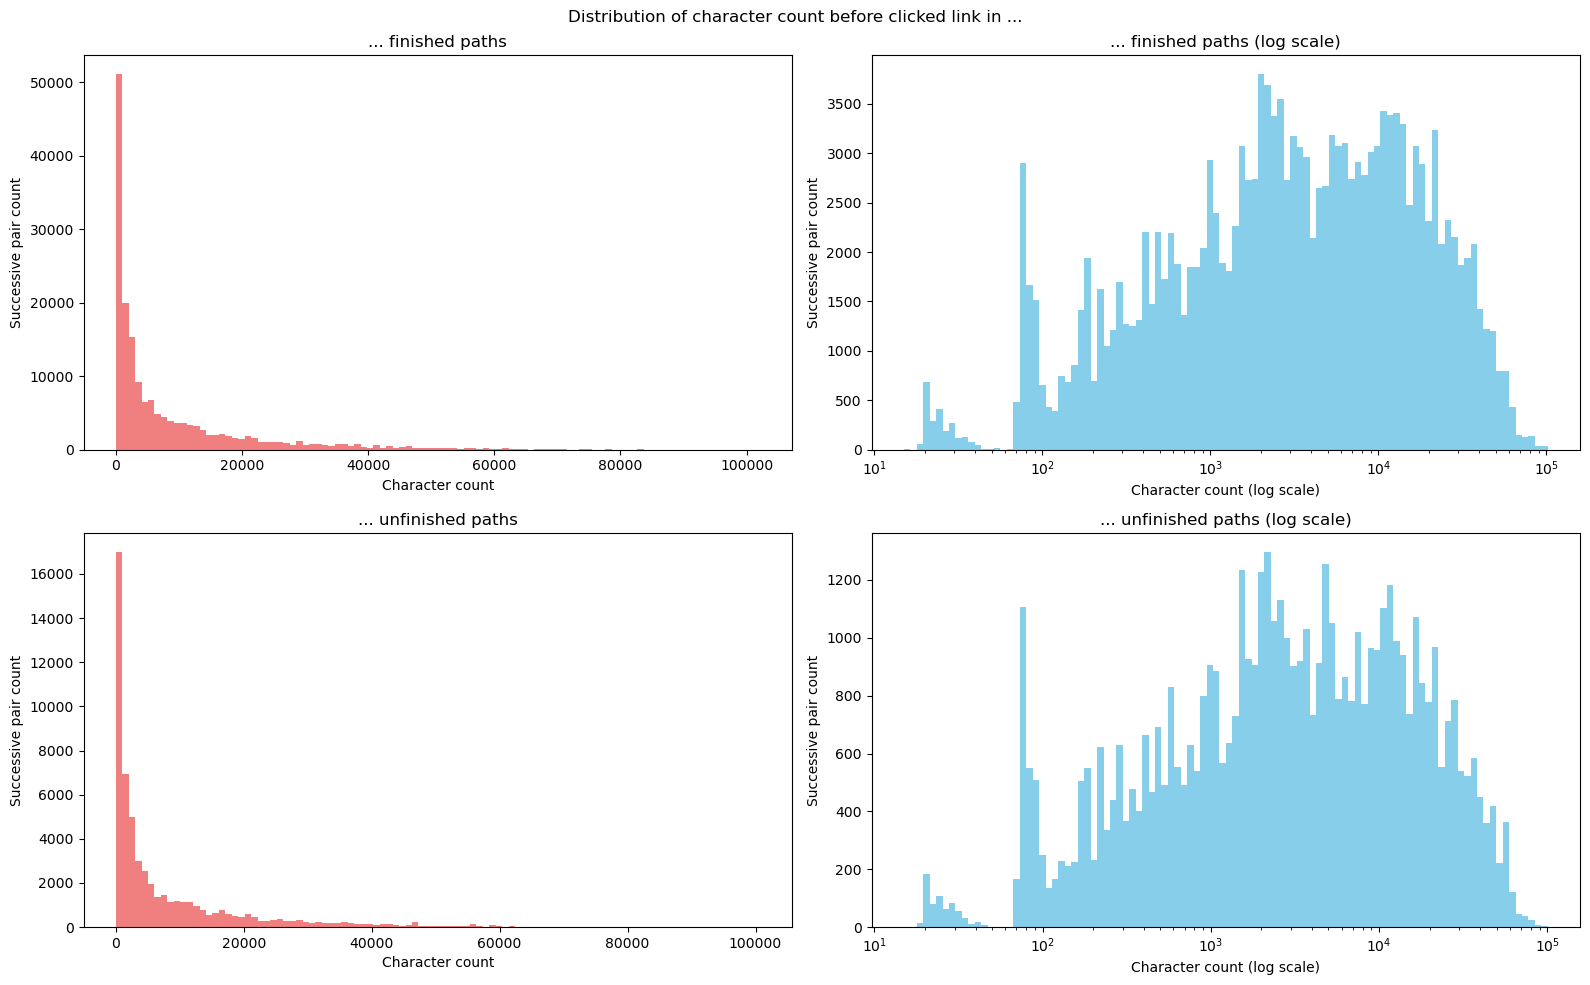

In [7]:
pd.options.mode.chained_assignment = None  # to remove warning

paths_finished_copy = paths_finished.copy(deep=True)
paths_unfinished_copy = paths_unfinished.copy(deep=True)


# Removing back clicks (<) and splitting paths
print("1) Removing back clicks and splitting paths...")


def remove_backclicks_and_split(paths):
    for i in tqdm(range(len(paths)), file=sys.stdout):
        paths["path"].iloc[i] = paths["path"].iloc[i].split(";")
        for item in paths["path"].iloc[i].copy():
            if item == "<":
                paths["path"].iloc[i].remove(item)
    return paths


paths_finished_copy = remove_backclicks_and_split(paths_finished_copy)
paths_unfinished_copy = remove_backclicks_and_split(paths_unfinished_copy)


# Grouping successive pairs
successive_pairs_finished = [
    [(x[i], x[i + 1]) for i in range(len(x) - 1)]
    for x in paths_finished_copy["path"].to_list()
]

successive_pairs_unfinished = [
    [(x[i], x[i + 1]) for i in range(len(x) - 1)]
    for x in paths_unfinished_copy["path"].to_list()
]


# Function that returns path to plaintext article
def path_to_plaintext(article_name):
    article_name_undsc = article_name.replace(" ", "_")
    ALL_PLAINTEXT = "./data/plaintext_articles/"
    path = ALL_PLAINTEXT + article_name_undsc + ".txt"
    return path


# Function returning character count before clicked link of a sucessive pair (that is, position of second word in seccessive pair in first word in pair's article)
def find_word_position(successive_pair):
    target_words = successive_pair[1].replace("_", " ")
    article = path_to_plaintext(successive_pair[0])

    with open(article, encoding="utf8") as file:
        content = file.read()
        try:
            return content.index(target_words)
        except:  # Mistake because sometimes word in is html file but not in text file. To be treated later.
            # print(f"The group of words '{successive_pair[1]}' was not found in the file '{successive_pair[0]}'.")
            return 0


# Computing maximum path length
finished_path_length = paths_finished_copy["path"].apply(lambda x: len(x))
finished_max_path_length = finished_path_length.max()
unfinished_path_length = paths_unfinished_copy["path"].apply(lambda x: len(x))
unfinished_max_path_length = unfinished_path_length.max()


# Compute position for every pair in finished paths
print(
    "2) Computing position for every successive pair in finished and unfinished paths..."
)


def compute_position_for_all_pairs(successive_pairs, max_path_length):
    positions_of_next_clicked_link = np.zeros(
        (len(successive_pairs), max_path_length - 1)
    )
    for i in tqdm(range(len(successive_pairs)), file=sys.stdout):
        for j in range(len(successive_pairs[i])):
            positions_of_next_clicked_link[i, j] = find_word_position(
                successive_pairs[i][j]
            )

    # Computing average position of next clicked link
    average_position = positions_of_next_clicked_link[
        np.nonzero(positions_of_next_clicked_link)
    ].mean()

    return positions_of_next_clicked_link, average_position


(
    positions_of_next_clicked_link_finished,
    average_position_finished,
) = compute_position_for_all_pairs(successive_pairs_finished, finished_max_path_length)
(
    positions_of_next_clicked_link_unfinished,
    average_position_unfinished,
) = compute_position_for_all_pairs(
    successive_pairs_unfinished, unfinished_max_path_length
)


# Looking at the character count before clicked link
print(
    "3) Looking at character count before clicked link for every edge and for every player..."
)
print(
    "Average character count before clicked link in finished paths",
    "%.2f" % average_position_finished,
    "\nAverage character count before clicked link in unfinished paths",
    "%.2f" % average_position_unfinished,
)


def plot_2_histograms(positions_of_next_clicked_link, finished, ax):
    # Histogram on linear and log scale scale
    axis = ax[0]
    hist, bins, _ = axis.hist(
        positions_of_next_clicked_link[np.nonzero(positions_of_next_clicked_link)],
        bins=100,
        color="lightcoral",
    )
    if finished == True:
        axis.set_title(
            "... finished paths"
        )
    else:
        axis.set_title(
            "... unfinished paths"
        )
    axis.set_xlabel("Character count")
    axis.set_ylabel("Successive pair count")

    # Histogram on log scale
    logbins = np.logspace(
        np.log10(bins[0]), np.log10(bins[-1]), len(bins)
    )  # Use non-equal bin sizes, such that they look equal on log scale.
    axis = ax[1]
    axis.hist(
        positions_of_next_clicked_link[np.nonzero(positions_of_next_clicked_link)],
        bins=logbins,
        color="skyblue",
    )
    axis.set_xscale("log")
    if finished == True:
        axis.set_title(
            "... finished paths (log scale)"
        )
    else:
        axis.set_title(
            "... unfinished paths (log scale)"
        )
    axis.set_xlabel("Character count (log scale)")
    axis.set_ylabel("Successive pair count")

fig, axs = plt.subplots(2, 2, figsize=(16,10))

plot_2_histograms(positions_of_next_clicked_link_finished, finished=True, ax=axs[0])
plot_2_histograms(positions_of_next_clicked_link_unfinished, finished=False, ax=axs[1])

fig.suptitle('Distribution of character count before clicked link in ...')
fig.tight_layout()

plt.show()

The majority of players seams to not scroll to much before clicking on the next link. \
It would be interesting to validate this feature and statistically test whether there is a difference between finished and unfinised games.\
It is worth it to further investigate this feature, and see how it relates to good players. \
We can defenitely use this page position feature!
